## BIO322 MINI PROJECT A (Thomas Castiglione)


## 1. Exploration of the data


We first load and take a look at the training data:

In [1]:
data.full<-na.omit(read.csv(file.path("../data/training_data.csv")))

In [2]:
head(data.full)
dim(data.full)

,Intensity,VALENCE.PLEASANTNESS,SWEETORSOUR,complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,...,Psychotic.80,Psychotic.50,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50
,<chr>,<int>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,low,45,FALSE,302.0,208.33,5.952,19.698,34.491,21.523,39.571,...,0,0,1,0,1,0,1,0,1,0
2,high,49,TRUE,72.6,122.18,6.431,11.349,18.745,12.261,21.285,...,0,0,0,0,0,0,0,0,0,0
3,high,56,TRUE,259.0,242.29,7.572,20.832,32.167,21.693,35.535,...,0,0,1,0,1,1,1,0,1,1
4,high,7,FALSE,56.6,88.12,6.294,7.537,14.189,7.955,16.080,...,0,0,0,0,0,0,0,0,0,0
5,low,51,FALSE,84.7,136.21,6.191,12.876,21.629,14.023,24.701,...,0,0,0,0,0,0,0,0,0,0
6,high,21,FALSE,160.0,192.28,6.409,17.644,29.723,19.000,33.740,...,0,0,0,0,1,0,1,0,1,0


[1]  708 4872

to get the same type for all predictors(integers and/or decimals), we are going to transform the predictors "Intensity" as integer
(create new predictors for "high" and "low" with values 0 or 1 (one-hot-coding)). We remove the predictor "SWEETORSOUR".

In [3]:
data.full$Intensity_high<-ifelse(data.full$Intensity=='high',1,0)
data.full$Intensity_low<-ifelse(data.full$Intensity=='low',1,0)
data.full<-data.full[,-which(colnames(data.full)=='Intensity')]
data.full<-data.full[,-which(colnames(data.full)=='SWEETORSOUR')]    #remove sweetorsour because not in final test set

In [4]:
head(data.full)
numtypes<-apply(data.full,2,function(x) typeof(x)%in%c('double','integer'))
cat('Number of predictor with type other than double of integer : ',length(which(numtypes != T)))


,VALENCE.PLEASANTNESS,complexity.from.pubmed,MW,AMW,Sv,Se,Sp,Si,Mv,Me,...,Hypertens.80,Hypertens.50,Hypnotic.80,Hypnotic.50,Neoplastic.80,Neoplastic.50,Infective.80,Infective.50,Intensity_high,Intensity_low
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,45,302.0,208.33,5.952,19.698,34.491,21.523,39.571,0.563,0.985,...,1,0,1,0,1,0,1,0,0,1
2,49,72.6,122.18,6.431,11.349,18.745,12.261,21.285,0.597,0.987,...,0,0,0,0,0,0,0,0,1,0
3,56,259.0,242.29,7.572,20.832,32.167,21.693,35.535,0.651,1.005,...,1,0,1,1,1,0,1,1,1,0
4,7,56.6,88.12,6.294,7.537,14.189,7.955,16.080,0.538,1.014,...,0,0,0,0,0,0,0,0,1,0
5,51,84.7,136.21,6.191,12.876,21.629,14.023,24.701,0.585,0.983,...,0,0,0,0,0,0,0,0,0,1
6,21,160.0,192.28,6.409,17.644,29.723,19.000,33.740,0.588,0.991,...,0,0,1,0,1,0,1,0,1,0


Number of predictor with type other than double of integer :  0

Now, we only have predictors with numeric values.
Let's check if there is predictors with variance=0 for all samples:

In [5]:
dim(data.full[,apply(data.full,2,function(x) all(var(x)==0))])[2]

[1] 1842

There is 1842 predictors with variance=0, so we can remove them (they cannot have any impact on the VALENCE.PLEASANTNESS prediction values of a model).

In [6]:
data.no.zeros<-(data.full[,apply(data.full,2,function(x)!all(var(x)==0))])
dim(data.no.zeros)[2]

[1] 3030

We visualize the distribution of VALENCE.PLEASANTNESS and make a pairplot of some randomly chosen data to get a general idea of the data distribution.

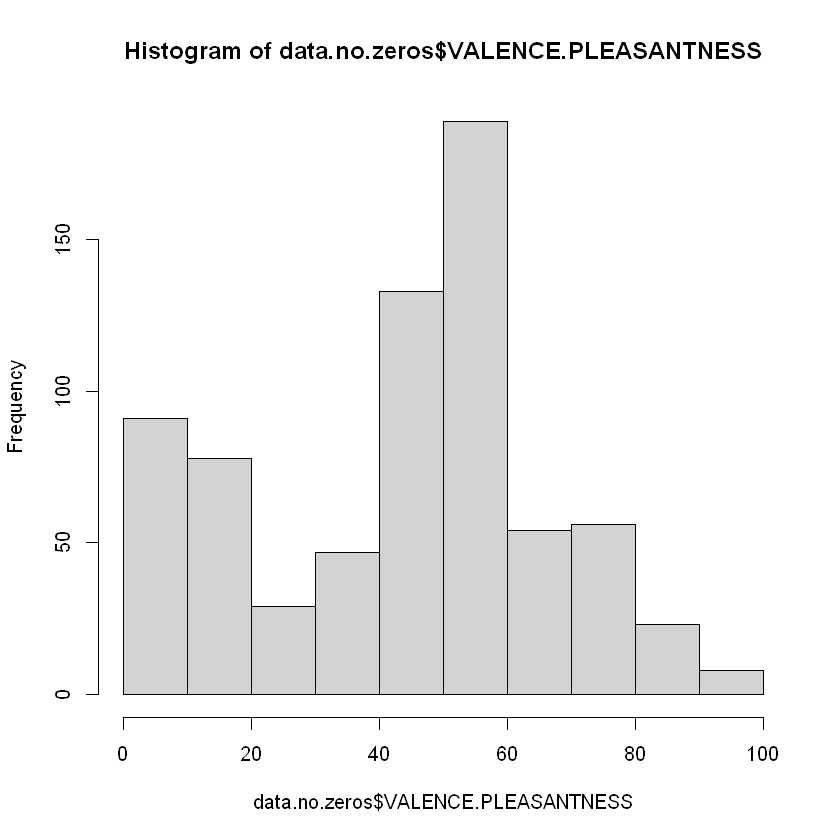

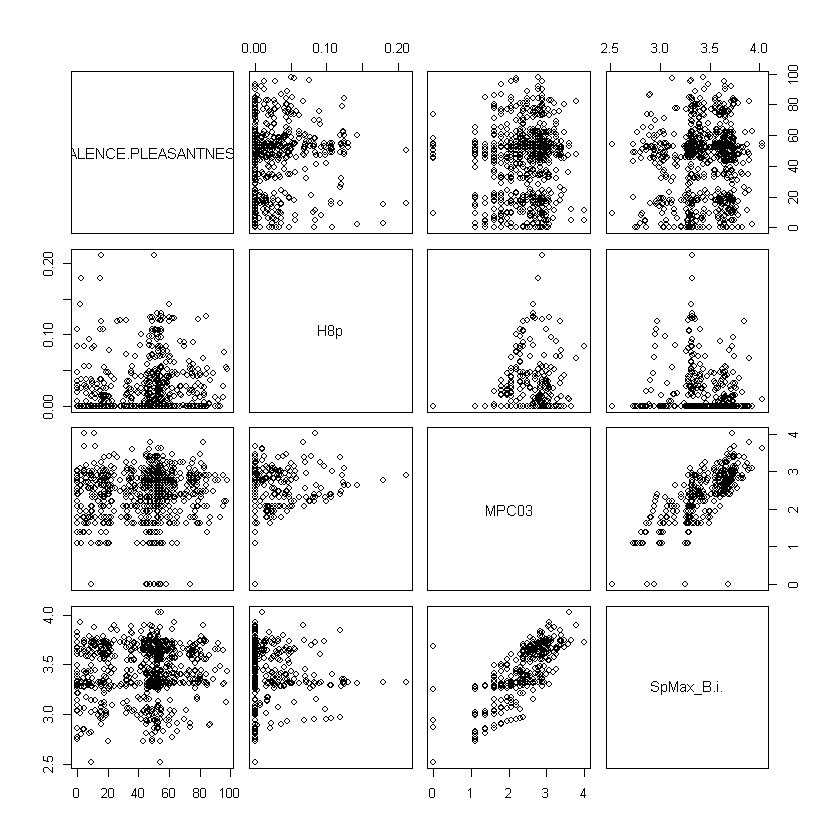

In [7]:
set.seed(21)
hist(data.no.zeros$VALENCE.PLEASANTNESS)
pairs(data.no.zeros[c(1,sample(1:ncol(data.no.zeros),3))],cex.labels=1.1)

We can see that the VALENCE.PLEASANTNESS distribution does not seems to follow any explicit distribution law.

Also, in the chosen plotted data, we cannot really gess any direct influence of a predictor on VALENCE.PLEASANTNESS, but we can guess some predictors that seem to be correlated (like SpMax_B.i. and MPC03 for example) 

We then check for pairwise correlation:

In [8]:
library(corrplot)

corrplot 0.84 loaded



In [9]:
cor.mat<-cor(data.no.zeros)

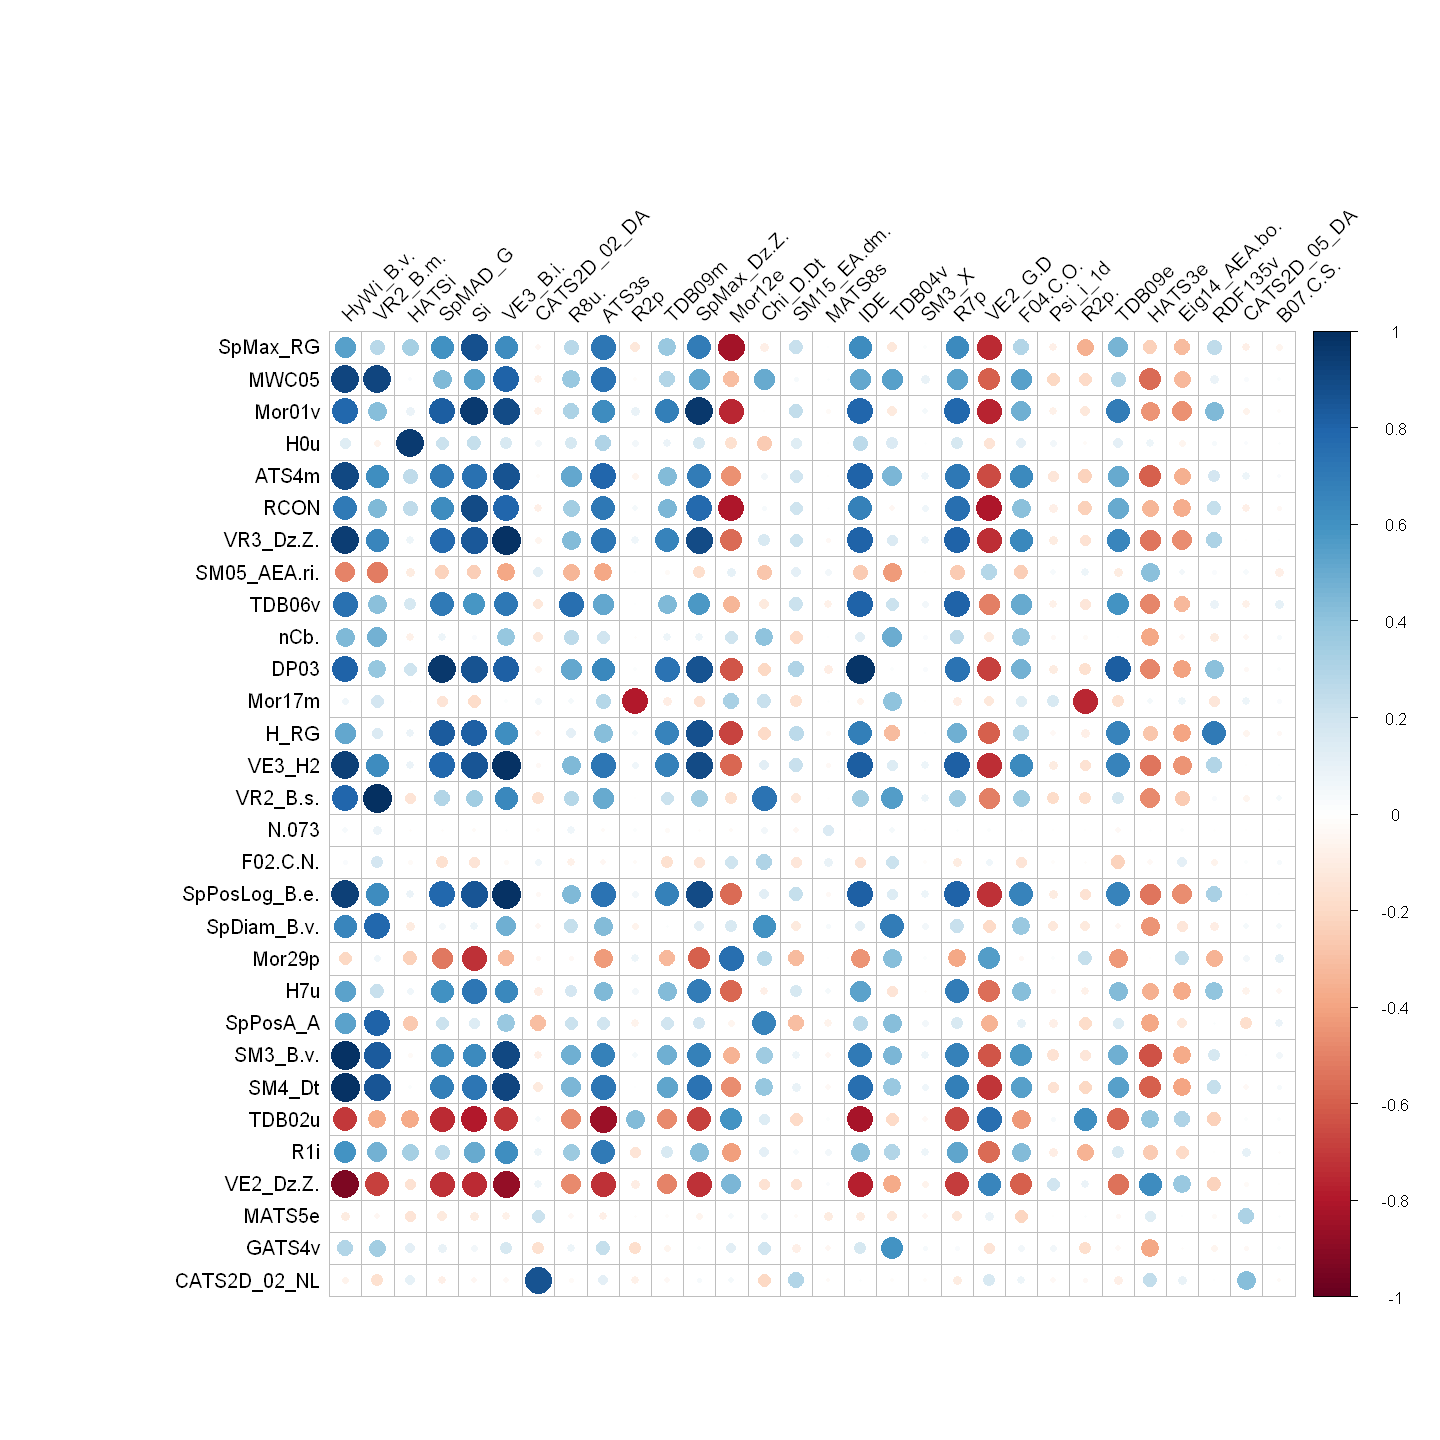

In [10]:
set.seed(2)
options(repr.plot.width=12, repr.plot.height=12) #graphical parameters
corrplot(cor.mat[sample(1:ncol(data.no.zeros),30),sample(1:ncol(data.no.zeros),30)], order="hclust", tl.col="black", tl.srt=45)
options(repr.plot.width=8, repr.plot.height=8)

We can see on this plot of selected predictors that there is some highly correlated predictors. We will remove one of each predictors in pairs having pairwise correlation > 0.99. Later will compare the models based on the data with/without these correlated predictors.

In [11]:
flattenCorrMatrix <- function(cormat) {        #function found online and modified, used to get a more comfortable correlation data.frame
  ut <- upper.tri(cormat)
  data.frame(row = rownames(cormat)[row(cormat)[ut]],
    column = rownames(cormat)[col(cormat)[ut]],
    cor  =(cormat)[ut])
}

In [12]:
cor.df<-flattenCorrMatrix(cor.mat)
max.cor.rows<-which(abs(cor.df$cor) > 0.99)
max.cor.pred<-cor.df[max.cor.rows,][-3]
dim(max.cor.pred[!duplicated(max.cor.pred$row),])[1]

[1] 1176

There is 1176 predictors pair with correlation > 0.99, we remove one of each of these.

In [13]:
data<-data.no.zeros
data<-data.no.zeros[,!colnames(data)%in%c(max.cor.pred$row)]
dim(data)[2]

[1] 1854

We have reduced the number of predictors from 4871 to 1853 (first column is the response), not bad ! (actually not sure now if this is not bad, we will compare the models later.)

## 2. linear methods

Let's firstly split the data in a training and test set (test set on kaggle is for later)

In [14]:
set.seed(1)
idx.train<-sample(nrow(data), nrow(data)*(2/3)) #2/3 taken into the training set because it will 
                                                #later be splitted again to get a validation set.
data.train<-data[idx.train,]
data.test<-data[-idx.train,]
dim(data.train)
dim(data.test)

[1]  472 1854

[1]  236 1854

**Simple linear regression with all the predictors**

Now let's run a simple linear regression on the whole training set. The result will be bad, since p>n it will largely overfit the data, but this result will serve us as baseline for the rest. 

In [15]:
basic.lin.fit<-lm(VALENCE.PLEASANTNESS ~ ., data.train)

In [16]:
train.pred<-predict(basic.lin.fit,data.train)
test.pred<-predict(basic.lin.fit, data.test)
train.RMSE<-sqrt(mean((data.train$VALENCE.PLEASANTNESS-train.pred)^2))
test.RMSE<-sqrt(mean((data.test$VALENCE.PLEASANTNESS-test.pred)^2))
cat("train RMSE: ", train.RMSE,"\n", "test RMSE: ", test.RMSE)

Warning message in predict.lm(basic.lin.fit, data.train):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(basic.lin.fit, data.test):
"prediction from a rank-deficient fit may be misleading"


train RMSE:  12.15531 
 test RMSE:  1421538170

We can see the huge test RMSE, coming from the largely overfitting model. 

**Cross-validation choice of best predictors and best number of predictors**

We are in the situation n<p, we find the best number of relevant predictors using 5-fold cross-validation on forward subsetting (best subset selection will ask to much computing):

In [17]:
library(leaps)
library(tidymodels)

-- Attaching packages ------------------------------------------------------------------------------ tidymodels 0.1.2 --

v broom     0.7.2      v recipes   0.1.15
v dials     0.0.9      v rsample   0.0.8 
v dplyr     1.0.2      v tibble    3.0.4 
v ggplot2   3.3.2      v tidyr     1.1.2 
v infer     0.5.3      v tune      0.1.2 
v modeldata 0.1.0      v workflows 0.2.1 
v parsnip   0.1.4      v yardstick 0.0.7 
v purrr     0.3.4      

-- Conflicts --------------------------------------------------------------------------------- tidymodels_conflicts() --
x purrr::discard() masks scales::discard()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
x recipes::step()  masks stats::step()



In [18]:
reg.fit.fwd<-regsubsets(VALENCE.PLEASANTNESS ~ ., data.train, method = 'forward', nvmax=150)
summary.reg<-summary(reg.fit.fwd)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1563  linear dependencies found"


Reordering variables and trying again:


The warning "linear dependencies found" is a consequence of n < p for regsubset, since this function was at first written for data with n > p. It will not have any impact for the rest of the code.

In [19]:
predict.regsubsets<-function(object,newdata,nb,formula=as.formula(object$call[2])){        #taken from lecture 5
    mat=model.matrix(formula,newdata)                                              
    coefs=coef(object, id=nb)
    xvars=names(coefs)
    return(mat[,xvars]%*%coefs)
}
fit_and_eval<-function(fold,formula=VALENCE.PLEASANTNESS ~ .){
    fit<-regsubsets(formula, analysis(fold), method='forward', nvmax=50,really.big=T)
    valid.set<-assessment(fold)
    sapply(1:(fit$nvmax-1),
           function(nb) mean((valid.set$VALENCE.PLEASANTNESS - predict(fit, valid.set, nb, formula))^2))
}


Running 5-fold cross-validation on the number of predictors. *(slow running cell)*

In [20]:
set.seed(5)
valid.data<-vfold_cv(data.train,v=5)
cv.errors<-sapply(valid.data$splits,fit_and_eval)
mean.cv.errors<-rowMeans(cv.errors)

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1592  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1595  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1602  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1597  linear dependencies found"


Reordering variables and trying again:


Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
"1595  linear dependencies found"


Reordering variables and trying again:


Best number of predictors is:  3

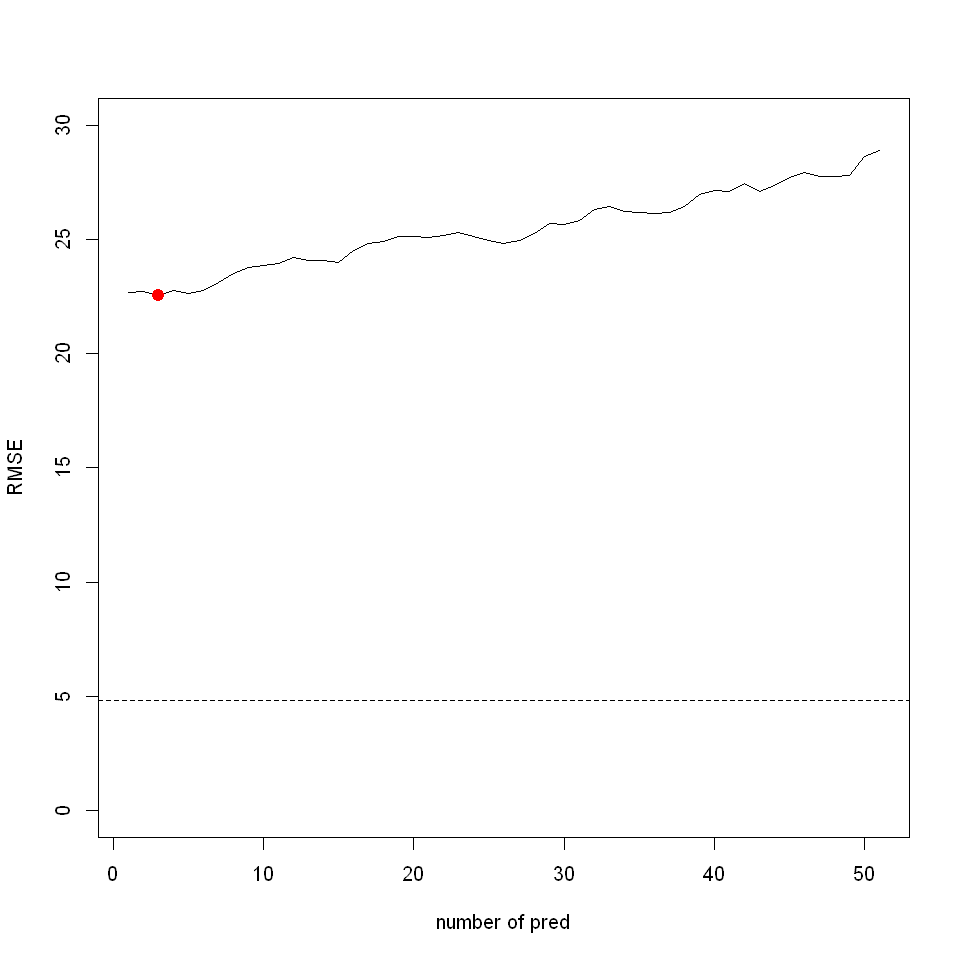

In [21]:
plot(sqrt(mean.cv.errors), type='l', ylim=c(0,30), ylab='RMSE', xlab='number of pred')
cv.min = which.min(mean.cv.errors)
points(cv.min, sqrt(mean.cv.errors[cv.min]), col = "red", cex = 2, pch = 20)
abline(sqrt(sd(data.train$VALENCE.PLEASANTNESS)), 0, lty = "dashed")
cat('Best number of predictors is: ',cv.min)

In [22]:
reg.test.pred<-predict.regsubsets(reg.fit.fwd, data.test, cv.min, formula=VALENCE.PLEASANTNESS ~ .)
reg.test.RMSE<-sqrt(mean((data.test$VALENCE.PLEASANTNESS-reg.test.pred)^2))
cat('test RMSE with cross-validation choice of predictors: ',reg.test.RMSE)

test RMSE with cross-validation choice of predictors:  23.25422

We get an RMSE of 23.25 on the test set using cross-validation to choose the predictors using only 3 predictors. 

**Lasso regularization**

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.0-2



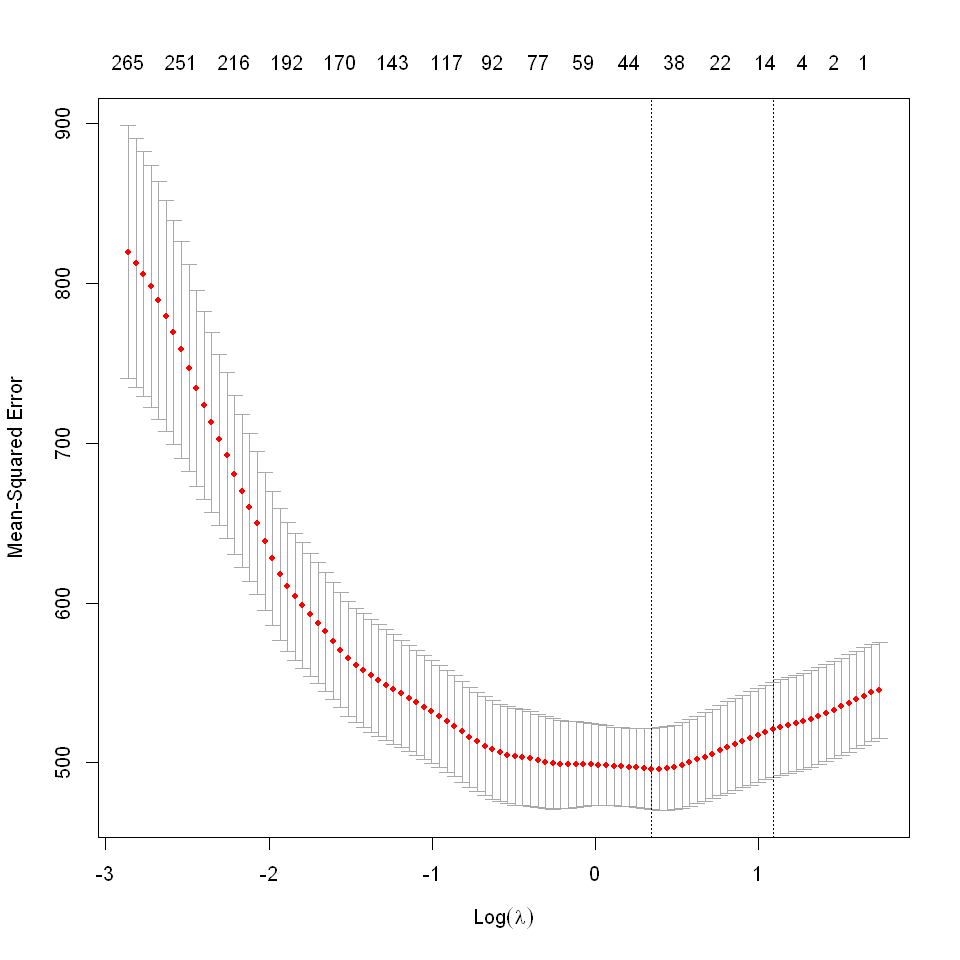

In [23]:
library(glmnet)
set.seed(10)
cv.lasso <- cv.glmnet(as.matrix(data.train[,-1]), data.train$VALENCE.PLEASANTNESS, alpha = 1)
plot(cv.lasso)

In [24]:
best.lasso <- glmnet(as.matrix(data.train[,-1]),data.train$VALENCE.PLEASANTNESS, alpha = 1, lambda = cv.lasso$lambda.min)
lasso.test.pred<-predict(best.lasso, as.matrix(data.test[,-1]))
lasso.test.RMSE<-sqrt(mean((data.test$VALENCE.PLEASANTNESS-lasso.test.pred)^2))
cat('test RMSE of lasso regularized model: ',lasso.test.RMSE)

test RMSE of lasso regularized model:  21.60518

In [25]:
set.seed(1)
cv.lasso.with.corr <- cv.glmnet(as.matrix(data.no.zeros[idx.train,-1]), data.no.zeros$VALENCE.PLEASANTNESS[idx.train], alpha = 1)
best.lasso.with.corr <- glmnet(as.matrix(data.no.zeros[idx.train,-1]),data.no.zeros$VALENCE.PLEASANTNESS[idx.train], alpha = 1, lambda = cv.lasso.with.corr$lambda.min)
lasso.with.corr.test.pred<-predict(best.lasso.with.corr, as.matrix(data.no.zeros[-idx.train,-1]),s=cv.lasso.with.corr$lambda.min)
lasso.with.corr.test.RMSE<-sqrt(mean((data.no.zeros$VALENCE.PLEASANTNESS[-idx.train]-lasso.with.corr.test.pred)^2))
cat('test RMSE of lasso regularized model with correlated predictors', lasso.with.corr.test.RMSE)

test RMSE of lasso regularized model with correlated predictors 21.73853

We see that dropping more thant thousand of highly correlated predictors almost does not impact the test error. We will continue to use the data without correlated predictors for computing efficiency.

We see also that lasso regularization is more efficient and optimized than cross-validated forward subset selection for the choice of predictors here.

In conclusion for linear methods, linear regression using cross-validated Lasso regularization gives us the best result.

#### create predictions for kaggle test set with lasso regulation

Formatting the final test data as we did for the training data:

In [26]:
data.final.test.full<-read.csv(file.path("../data/test_data.csv"))
data.final.test.full$Intensity_high<-ifelse(data.final.test.full$Intensity=='high',1,0)
data.final.test.full$Intensity_low<-ifelse(data.final.test.full$Intensity=='low',1,0)
data.final.test.full<-data.final.test.full[,-which(colnames(data.final.test.full)=='Intensity')]
data.final.test<-data.final.test.full[,colnames(data.final.test.full)%in%colnames(data)]

In [27]:
lasso.fit.sub<-glmnet(as.matrix(data[,-1]),data$VALENCE.PLEASANTNESS, alpha=1, lambda=cv.lasso$lambda.min)
lasso.test.pred<-predict(lasso.fit.sub, as.matrix(data.final.test))#s=cv.lasso$lambda.min)
lasso.pred.sub<-cbind(which(lasso.test.pred==lasso.test.pred),lasso.test.pred)
colnames(lasso.pred.sub)<-c("id","VALENCE.PLEASANTNESS")

In [28]:
write.csv(lasso.pred.sub,"../submissions/submission_lasso.csv", row.names=F)

We get a score of 22.8 on the kaggle test. This is bigger than expected from the data.test results we got, it may come from overfitting when we make the linear regression on the whole data, but we are not sure about this.

## 3. non-linear methods

### neural network

We will use the library `keras` to fit artificial neural networks on the data. First we need to explore the possibles neural network architectures, meaning number of layers, number of neurons per layer, activation function of the neurons, wether or not regularize the network. These are all questions that do not have explicit answers !

In [29]:
library(keras)


Attaching package: 'keras'


The following object is masked from 'package:yardstick':

    get_weights




In [30]:
data.train.x<-data.train[,-1]
data.train.y<-data.train[,1]
data.test.x<-data.test[,-1]
data.test.y<-data.test[,1]

We define a function that compile and fit a neural network.

In [31]:
compile_and_fit<-function(nn,data.x=data.train.x, data.y=data.train.y, valid.split=NULL,
                          valid.data=NULL, callbacks=NULL){
    nn %>% compile(loss='mse', optimizer = 'adam')
    nn %>% fit(as.matrix(data.x),
                    data.y,
                    validation_split=valid.split,
                    validation_data=valid.data,
                    epochs=100,
                    callbacks=callbacks)
    
}

We create our neural network:

The following function replicates the same neural network training and evaluation with different seeds:

In [32]:
keras.nn<-function(seed,callbacks=NULL){
    tensorflow::tf$random$set_seed(seed) #alternative to use_session_with_seed() in my keras version.
    nn<-keras_model_sequential()
    nn %>%
        layer_dense(units=60, activation='relu', input_shape = c(1853), name = 'dense_input') %>%
        layer_dense(units=80, activation='relu', name = 'dense_2') %>%
        layer_dropout(rate=.1)%>%
        layer_dense(units=40, activation='relu', name = 'dense_3') %>%
        layer_dense(units=10, activation='relu', name = 'dense_4') %>%
        layer_dense(units=10, activation='relu', name = 'dense_5') %>%
        layer_dense(units=10, activation='relu', name = 'dense_6') %>%
        layer_dense(units=1, activation='linear', name = 'dense_output')
     
    hist<-compile_and_fit(nn,valid.split=0.1,callbacks=callbacks)
    ifelse(callbacks == NULL,,hist$params$epochs<-length(hist$metrics$loss))
    if(seed==1)print(plot(hist))
    evaluate(nn,as.matrix(data.test.x),data.test.y)
}

The neural network defined in the function above is the best we have found after tunning them (see report for tunning method).

Now we evaluate the neural network on d different seeds and plot one of the loss evolutions:

`geom_smooth()` using formula 'y ~ x'



 RMSE mean on the test set over  8  different seeds:  21.62316

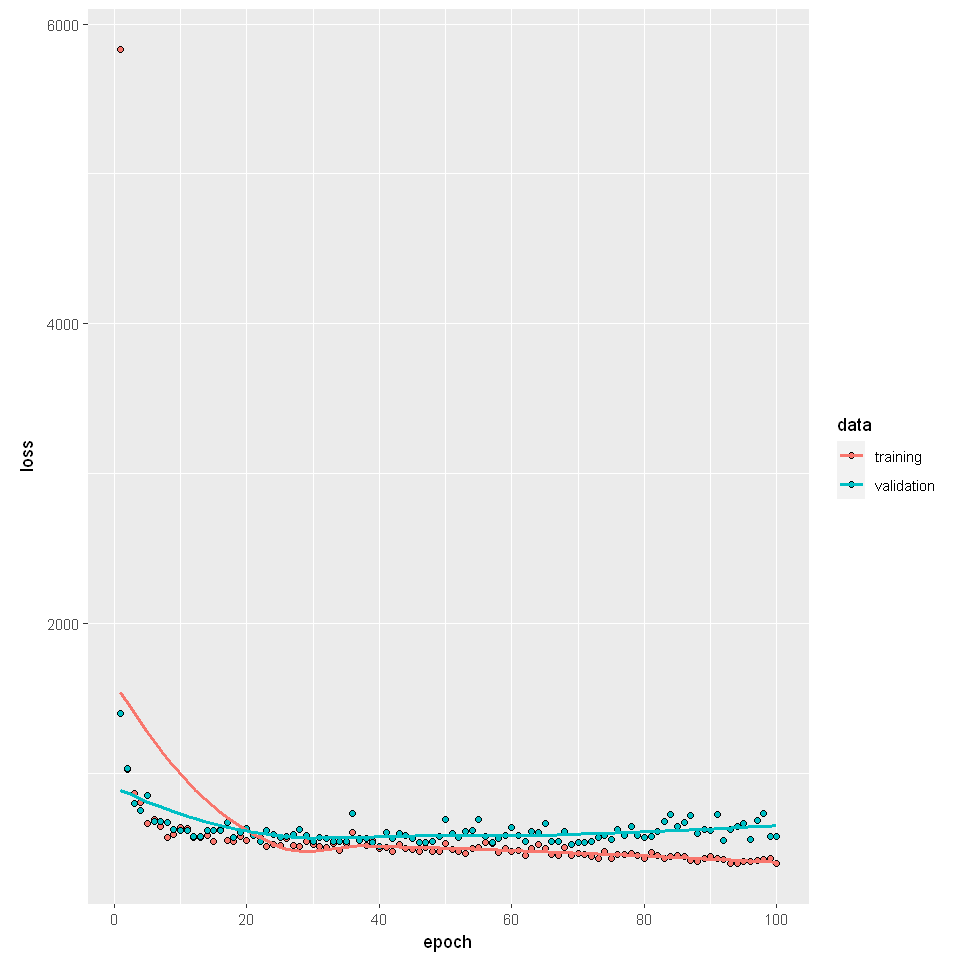

In [33]:
d<-8
keras.res<-sapply(1:d,keras.nn)
cat(' RMSE mean on the test set over ',d,' different seeds: ',sqrt(mean(keras.res)))

We also try it with early stoppage:

`geom_smooth()` using formula 'y ~ x'



 RMSE mean on the test set over  8  different seeds + early stopping :  21.78098

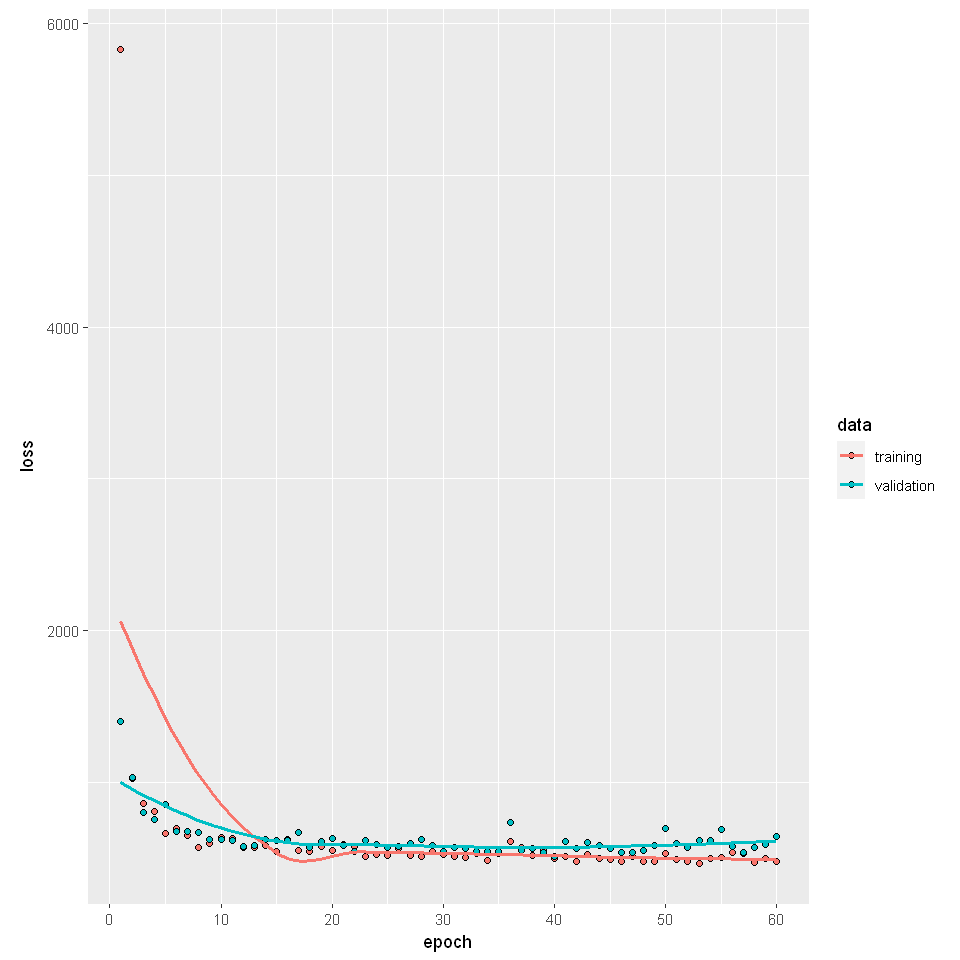

In [34]:
keras.res<-sapply(1:d,keras.nn,callbacks=callback_early_stopping(monitor='val_loss',patience = 20))
cat(' RMSE mean on the test set over ',d,' different seeds + early stopping : ',sqrt(mean(keras.res)))

We tried early stoppage when our networks began to overfit too quickly (when there was too much unneccessary layers/neurons). But this is not usefull for the network design before,as we can see from its RMSE with early stoppage.

Here we set the neural network with the best hyper-parameters we got to make the submission:

In [35]:
tensorflow::tf$random$set_seed(1)
nnS<-keras_model_sequential()
nnS%>%
        layer_dense(units=60, activation='relu', input_shape = c(1853), name = 'dense_input') %>%
        layer_dense(units=80, activation='relu', name = 'dense_2') %>%
        layer_dropout(rate=.1)%>%
        layer_dense(units=40, activation='relu', name = 'dense_3') %>%
        layer_dense(units=10, activation='relu', name = 'dense_4') %>%
        layer_dense(units=10, activation='relu', name = 'dense_5') %>%
        layer_dense(units=10, activation='relu', name = 'dense_6') %>%
        layer_dense(units=1, activation='linear', name = 'dense_output')
summary(nnS)

nnS %>% compile(loss='MSE',optimizer='adam')

nnS.fitted<-nnS %>% fit(as.matrix(data[,-1]),      #we train it on the whole data, so we use early stopping to
                    data[,1],                      #prevent overfitting
                    epochs=100,
                    validation_split=0.1,
                    callbacks=callback_early_stopping(monitor='val_loss',patience = 20)    
                    )

Model: "sequential_16"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_input (Dense)                 (None, 60)                      111240      
________________________________________________________________________________
dense_2 (Dense)                     (None, 80)                      4880        
________________________________________________________________________________
dropout_16 (Dropout)                (None, 80)                      0           
________________________________________________________________________________
dense_3 (Dense)                     (None, 40)                      3240        
________________________________________________________________________________
dense_4 (Dense)                     (None, 10)                      410         
________________________________________________________________________________
dense

`geom_smooth()` using formula 'y ~ x'



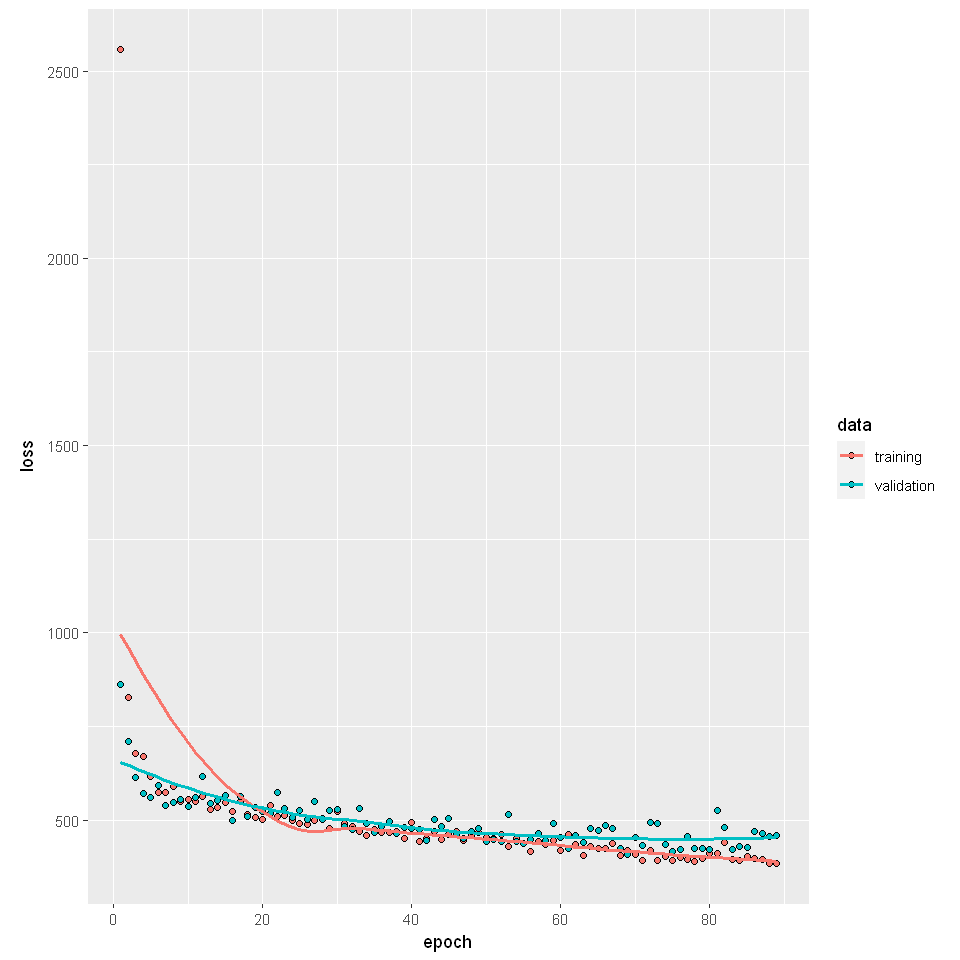

In [36]:
nnS.fitted$params$epochs<-length(nnS.fitted$metrics$loss)
plot(nnS.fitted)

Making sure that the loss seems ok using a small validation set, because going from fitting on the training set to fitting the whole data could lead to overfit.

In [37]:
pred<-predict(nnS,as.matrix(data.final.test))

In [38]:
pred.sub<-cbind(which(pred==pred),pred)
colnames(pred.sub)<-c("id","VALENCE.PLEASANTNESS")

In [39]:
write.csv(pred.sub,"../submissions/BEST_submisson_nn_60-80-d01-40-10-10-10-1_new_try.csv", row.names=F)

### Gradient boosting

Gradient boosting is, we think, the other non-linear method being most likely to work.

In [40]:
library(xgboost)


Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




The following function build and evaluate a gradient boosting method with given hyper-parameters:

In [41]:
boosting<-function(d,B,eta){
    boost<-xgboost(as.matrix(data.train.x),label = data.train.y,
                objective="reg:squarederror",
                eta=eta,
                max_depth=d,
                nrounds=B,
                verbose=0)
    boost.train.pred<-predict(boost,as.matrix(data.train.x))
    boost.test.pred<-predict(boost,as.matrix(data.test.x))
    boost.train.RMSE<-sqrt(mean((data.train.y-boost.train.pred)^2))
    boost.test.RMSE<-sqrt(mean((data.test.y-boost.test.pred)^2))
    data.frame(train.RMSE=boost.train.RMSE,testRMSE=boost.test.RMSE)
}

First we look at the impact of the nrounds hyper-parameter (B) with a max_depth chosen of 4.  *(slow running cell)*

In [42]:
B_l<-c(100,500,1000,2000,3000,4000,5000)
df.B<-sapply(B_l,boosting,d=4,eta=0.001)

the smallest test RMSE is obtained with B =  4000  and is :  22.87079

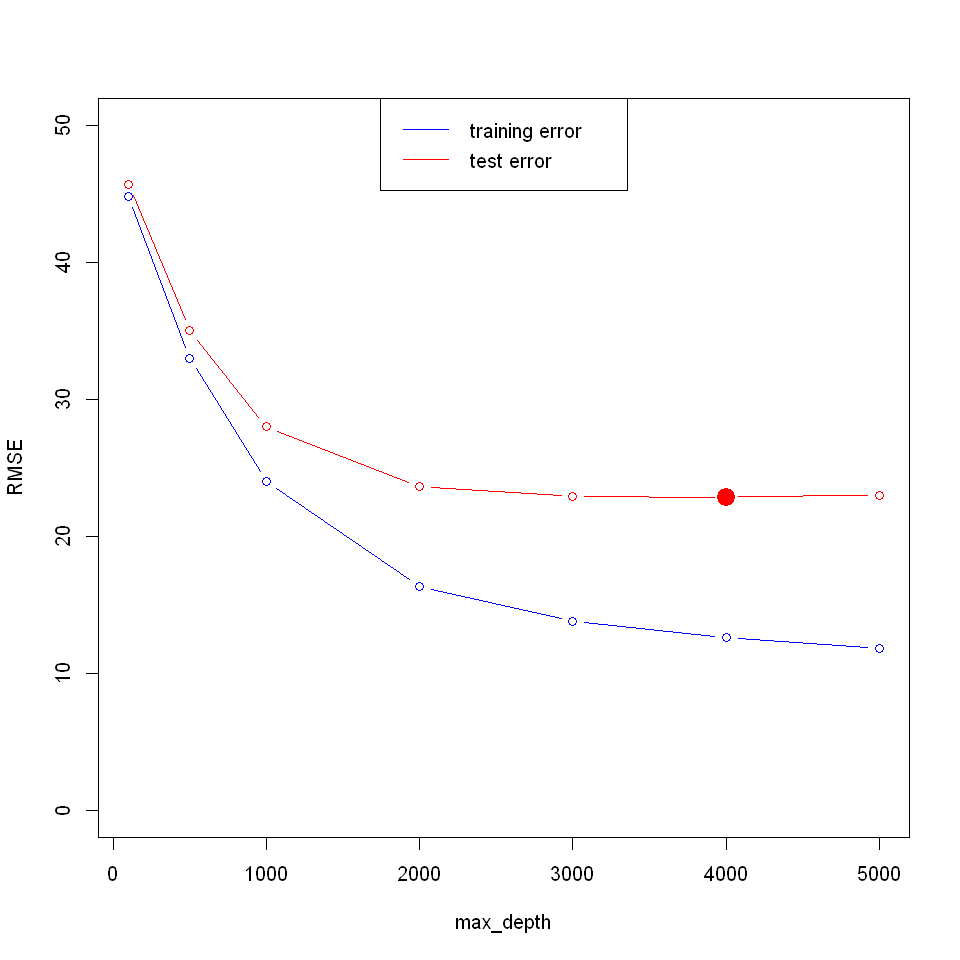

In [43]:
plot(B_l,df.B[1,],type = 'b', col='blue',ylim=c(0,50),xlab='max_depth', ylab='RMSE')
lines(B_l,df.B[2,],type='b',col='red')
B.min<-which.min(df.B[2,])
B.min.test.RMSE<-as.numeric(df.B[2,B.min])
points(B_l[B.min],df.B[2,B.min], col='red', pch=20,cex=3)
legend("top",legend=c('training error', 'test error'),col=c('blue','red'),lty=1)
cat('the smallest test RMSE is obtained with B = ', B_l[B.min], ' and is : ',B.min.test.RMSE)

Now we tune the max_depth parameter (d).    *(slow running cell)*

In [44]:
d_l<-1:5
df.d<-sapply(d_l,boosting,B=B_l[B.min],eta=0.001)

the smallest test RMSE is obtained with d =  2  and is :  22.63047

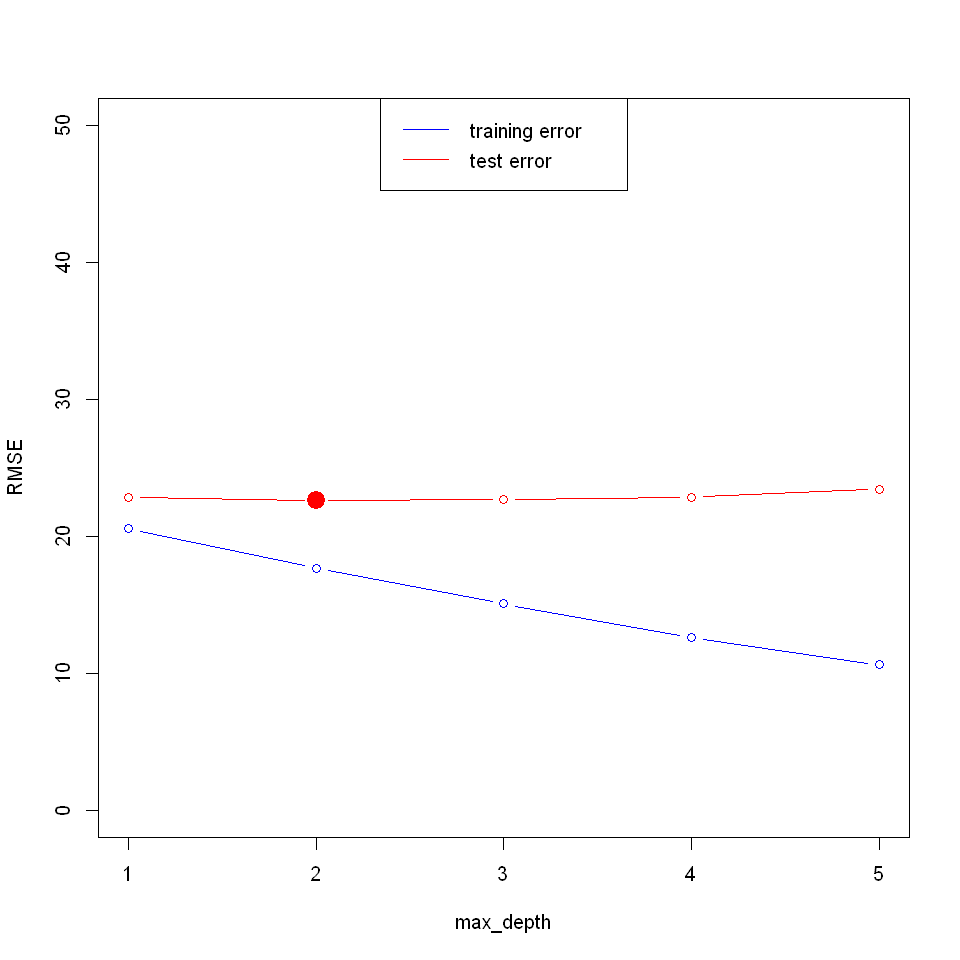

In [45]:
plot(d_l,df.d[1,],type = 'b', col='blue',ylim=c(0,50),xlab='max_depth', ylab='RMSE')
lines(d_l,df.d[2,],type='b',col='red')
d.min<-which.min(df.d[2,])
d.min.test.RMSE<-as.numeric(df.d[2,d.min])
points(d.min,df.d[2,d.min], col='red', pch=20,cex=3)
legend("top",legend=c('training error', 'test error'),col=c('blue','red'),lty=1)
cat('the smallest test RMSE is obtained with d = ', d.min, ' and is : ',d.min.test.RMSE)

The RMSE of 22.63 is not as good as the RMSE we got from neuron network. But we can get some really interesting information from the `importance` function from xgboost, giving us the predictors having the biggest impact on the result (from the gradient boosting method point of view):

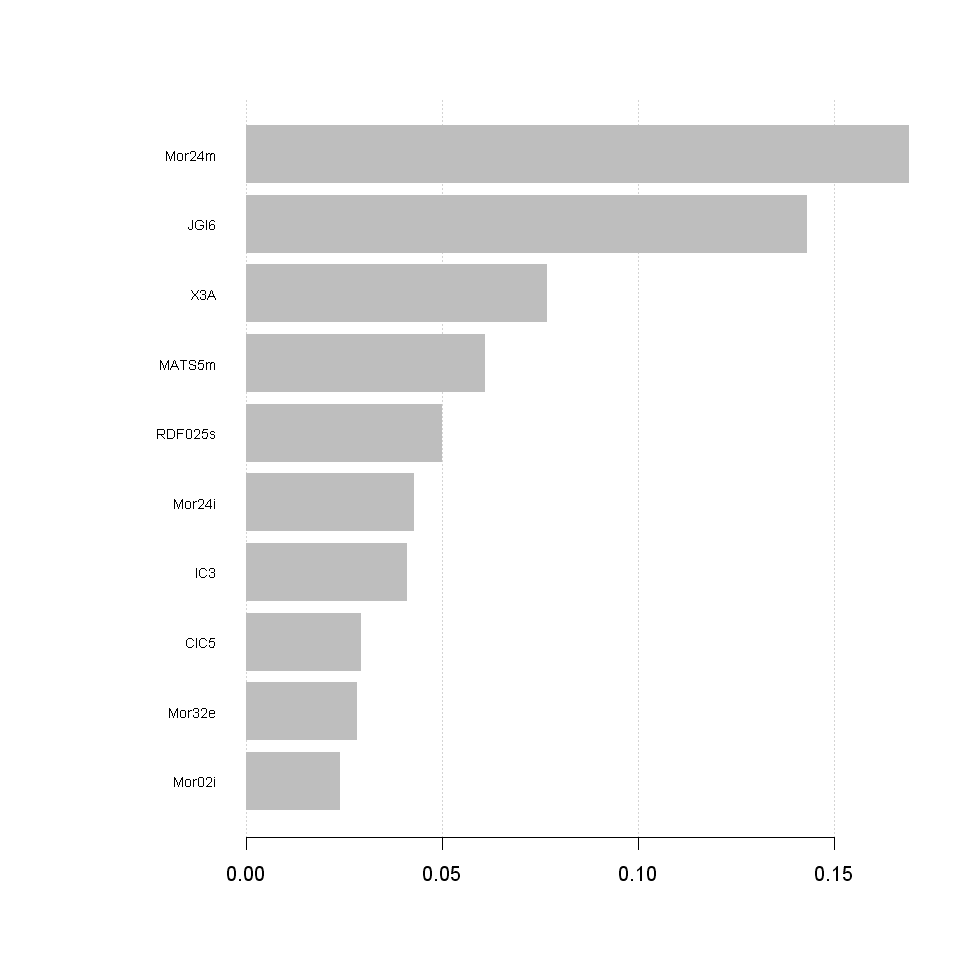

In [46]:
best.boost<-xgboost(as.matrix(data.train.x),label = data.train.y,
                objective="reg:squarederror",
                eta=0.001,
                max_depth=2,
                nrounds=1000,
                verbose=0)
xgb.plot.importance(xgb.importance(model=best.boost)[1:10])

We have chosen here a small B compare to the "best" one we got, to do not get to computationnaly expensive, here we just want to have an overview of the most important predictors. This plot may give an indication on why Lasso regularization works best on only 3 predictors, because there a factor ~2 between the 2 most important predictors and the next most important ones.  

### random forest

We wanted to check if the random forest method may be adapted to this data, but since random forest and boosting are somewhat close methods we think that we should get a similarly precise model. The motivation for trying this method is verifying our assumptions and put all chances in our side to do not miss an especially accurate method. We will not try bagging since it is basically a random forest fitted every time on all predictors.

In [47]:
library(randomForest)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine




as for neurons network, we try it over d seeds to get a better accuracy estimate. *(slow running cell)*

In [48]:
d<-5
random.forest<-function(seed){
    set.seed(seed)
    rforest<-randomForest(VALENCE.PLEASANTNESS~., data=data.train)
    rf.pred<-predict(rforest,data.test)
    mean((rf.pred - data.test$VALENCE.PLEASANTNESS)^2)
}
rforest.res<-sapply(1:d,random.forest)
cat('test RMSE using random forest is: ', sqrt(mean(rforest.res)))

test RMSE using random forest is:  22.65481

Also not bad RMSE, (like predicted it is close to the error we got from boosting), but the neural networks definitely seems to achieve little bit more accurate predictions for this data set.